In [1]:
# Set the data  directory to the parent directory of the script
wdir = dirname(@__DIR__)
cd(wdir)

In [2]:
using DelimitedFiles
using CSV
using DataFrames
using Plots
using Measures

In [3]:
include("src/EvoEpiModel.jl")

evolve_pop_EpiModel

In [4]:
# For plots
base = 12
lfs = base # Legend font size
alfs = base # axis label font size
tfs = base # title font size
atfs = base # axis ticks font size
ga = 0.3 # grid alpha
sizes =(600,400) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
annfs = 34
fonts2=font("Arial",9)
#

Plots.Font("Arial", 9, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [15]:
# Define parameters
# Selection coefficients  learned from SARS-CoV-2 temporal genomic data
selection_coeff = readdlm("data/selection_coeff_SC2.txt")[:];
# Fit a LogNormal distribution to beneficial selection coefficients
bf_effect_dist = fit(LogNormal, selection_coeff[selection_coeff .> 0.02]);
# Fit a Normal distribution to neutral selection coefficients between -0.02 and 0.02
nt_effect_dist = fit(Normal, selection_coeff[-0.02 .< selection_coeff .< 0.02]);
# Beneficial mutation rate
bf_m = 10^(-3)
# Neutral mutation rate
nt_m = 10^(-4)
# Generation time for acute cases
t_s = 2.0
# Parameters of LogNormal distribution for chronical generation times
# Mean 
mu_cd = 4.9
# Std 
sigmma_cd = 0.5
# Probability that the new host develops a chronic infection
pc = 1.6e-4
# Create a Param type with the defined parameters
parameters = Param(bf_m,nt_m, bf_effect_dist,nt_effect_dist, t_s, mu_cd, sigmma_cd, pc)
# Initialize case 0
# Intra-host population size
N_Vid = 1000
# Initial time
t0 = 0.0 
# ID of case 0
id = 1
# ancestor 
anc = 0
# Create an initial individual using the specified parameters
case0 = init_individual(id, t0,parameters.t_s, N_Vid, anc);

In [16]:
#Simulation with chronical cases `chronical_cases=true`
T=1000;# Total number of days 
pop_final,num_sick,rare_events,chronical_times=evolve_pop_EpiModel(case0,T,N_Vid,parameters,chronical_cases=true); 

In [17]:
# Fraction of mutations 
fraction_mut_variant_res=av_number_of_mut_variant(pop_final);
# Slope change 
(slope_vs_t,score)=slope_change_score(fraction_mut_variant_res[1:end])
#Smooth this slope with Savitzky–Golay filter
time_window=151
polinom_order=1
sg1 = savitzky_golay(append!(slope_vs_t,0.0),time_window, polinom_order);
sg2 = savitzky_golay(sg1.y, time_window, polinom_order);

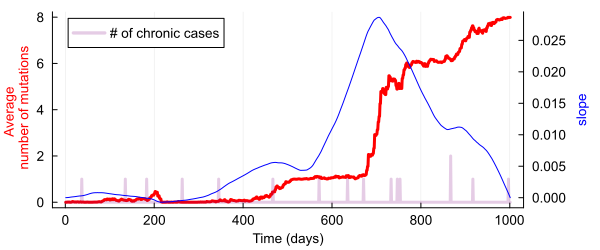

In [18]:
sizes =(600,250)
b=Plots.plot(1:1:T+1,fraction_mut_variant_res,y_guidefontcolor=:red,size=sizes,lw = 3,color=:red,label="",frame=true,fmt=:svg,legendfont=fonts2,guidefont=fonts2,ytickfont=fonts2,xtickfont=fonts2)
plot!(ylabel="Average \n number of mutations",xlabel="Time (days)")
Plots.plot!(1:1:T+1,rare_events,lw = 3,color=:purple,alpha=0.2,label="# of chronic cases")
Plots.plot!(twinx(),sg2.y, lw = 1,color=:blue,ylabel="slope",y_guidefontcolor=:blue,xlabel="",label="",frame=true,fmt=:svg,legendfont=fonts2,guidefont=fonts2,ytickfont=fonts2,xtickfont=fonts2)
plot!(legend=:topleft)
plot!(b, bottom_margin=3.00mm, left_margin=3.0mm, right_margin=4.0mm, margin=0.0mm)
xticks!(0:200:1000)